In [36]:
import retinapy
import retinapy.spikeprediction as sp
import retinapy.mea as mea
import numpy as np
import torch
import pathlib
import matplotlib as mpl
import plotly
import plotly.graph_objects as go
import plotly.subplots as subplots
from collections import defaultdict
import retinapy.spikedistancefield as sdf
import torch.nn as nn
import retinapy.nn
import torch.nn.functional as F
import scipy
import pathlib
from collections import namedtuple
import logging
from contextlib import contextmanager

In [37]:
class NotebookLogger:
    def info(self, msg):
        print(msg)
    def error(self, msg):
        print(msg)
    def warn(self, msg):
        print(msg)
    def warning(self, msg):
        print(msg)
_logger = NotebookLogger()

In [38]:
stimulus_pattern_path = "../data/ff_noise.h5"
stimulus_rec_path = "../data/ff_recorded_noise.pickle"
response_path = "../data/ff_spike_response.pickle"
rec_name = "Chicken_17_08_21_Phase_00"

rec = mea.single_3brain_recording(
    rec_name,
    mea.load_stimulus_pattern(stimulus_pattern_path),
    mea.load_recorded_stimulus(stimulus_rec_path),
    mea.load_response(response_path),
    include_clusters={21},
)

In [39]:
model_ckpt = "../out/exp/1/7/0/DistFieldCnn-9ds_3174in/checkpoint_best_loss_epoch-78.pth"
model_ckpt = "../out/exp/1/10/13/DistFieldCnn-9ds_3174in/checkpoint_best_loss_epoch-99.pth"
assert pathlib.Path(model_ckpt).resolve().exists()

AssertionError: 

In [ ]:
# Distfield model
input_len = 3174
output_len = 398
downsample = 9
df_trainable = sp.DistFieldCnnTrainableGroup.create_trainable(rec, sp.Configuration(downsample, input_len, output_len))
retinapy.models.load_model(df_trainable.model, model_ckpt)
retinapy.dataset.SpikeDistanceFieldDataset.DROP_RATE = 0
df_trainable.model.eval()
df_trainable.model.cuda()

# Count prediction model.
class DistFieldToSpikeCount(nn.Module):
    def __init__(self):
        super(DistFieldToSpikeCount, self).__init__()
        self.act = nn.Softplus()
        k = 5
        n = 9
        c = [25, 50, 50,
             50, 50, 100,
             100, 200, 200]
        assert len(c) == n
        expansion = 1
        self.layer1 = nn.Sequential(
            retinapy.nn.Residual1dBlock(
                1, c[0]*expansion, c[0], kernel_size=k, downsample=True
            ),
            *[
                retinapy.nn.Residual1dBlock(
                    c[i-1],
                    c[i]*expansion,
                    c[i],
                    kernel_size=k,
                    downsample=True,
                )
                for i in range(1, n)
            ],
        )
        self.layer2 = nn.Linear(in_features=c[-1], out_features=1)

    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.layer1(x)
        x = self.layer2(torch.flatten(x, start_dim=1))
        x = self.act(x)
        x = torch.flatten(x) # shape: [batch,]
        return x
    
class SpikeCountTrainable:
    def __init__(self, distfield_trainable, model, pred_len):
        self.df_trainable = distfield_trainable
        self.train_ds = df_trainable.train_ds
        self.val_ds = df_trainable.val_ds
        self.test_ds = df_trainable.test_ds  
        self.model = model
        self.pred_start = 100
        self.pred_len = pred_len # 10ms
        #self.loss_fn = nn.MSELoss()
        self.loss_fn = torch.nn.PoissonNLLLoss(log_input=False)
        self.ave_count = (10 / 1000) * 10 # 10 per second, counted in bins of 10ms
        self.sd = 0.2 # TODO
        
    def spikes_to_y(self, spikes):
        start = self.pred_start
        end = start + self.pred_len
        y = torch.sum(spikes[:,start:end], dim=1)
        return y
    
    def forward(self, sample):
        _, spikes, _ = sample
        spikes = spikes.float().cuda()
        with torch.no_grad():
            df_model_out, _ = self.df_trainable.forward(sample)
        model_in = df_model_out - 1.5 # The mean was about 1.5
        model_out = self.model(model_in)
        y = self.spikes_to_y(spikes)
        target = self.y_to_nn_output(y)
        loss = self.loss_fn(model_out, target=target)
        acc = torch.mean((y == torch.round(self.nn_output_to_y(model_out))).float())
        metrics = [retinapy._logging.Metric("accuracy", acc)]
        return model_out, loss, metrics
    
    def nn_output_to_y(self, nn_out):
        """Denormalize"""
        return nn_out
    
    def y_to_nn_output(self, y):
        return y
    
    def model_label(self):
        return f"DistFieldToSpikeCount-9ds_3174in_{self.pred_len}bins"
    
    def evaluate(self, val_dl):
        loss_meter = retinapy._logging.Meter("loss")
        predictions = []
        targets = []
        for (snippet, spikes, dist) in val_dl:
            spikes = spikes.cuda()
            gpu_sample = (snippet.cuda(), spikes, dist.cuda())
            model_out, loss, _ = self.forward(gpu_sample)
            batch_len = spikes.shape[0]
            loss_meter.update(loss.item(), batch_len)
            pred = self.nn_output_to_y(torch.round(model_out))
            y = self.spikes_to_y(spikes)
            predictions.append(pred)
            targets.append(y)
        p = torch.cat(predictions)
        t = torch.cat(targets)
        acc = (p == t).float().mean().item()
        pearson_corr = scipy.stats.pearsonr(p.cpu(), t.cpu())[0]
        metrics = [
            retinapy._logging.Metric("loss", loss_meter.avg),
            retinapy._logging.Metric("accuracy", acc),
            retinapy._logging.Metric("pearson_corr", pearson_corr)
        ]
        return metrics

In [40]:
def create_dataloaders(train_ds, val_ds, test_ds):
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=opt.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=20,
    )
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=opt.batch_size,
        # For debugging, it's nice to see a variety:
        shuffle=True,
        drop_last=True,
        num_workers=20,
    )
    test_dl = torch.utils.data.DataLoader(
        test_ds,
        batch_size=opt.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=20,
    )
    return train_dl, val_dl, test_dl

@contextmanager
def evaluating(model):
    """
    Context manager to set the model to eval mode and then back to train mode.

    This is used just in case there is an caught exception that leads to
    unexpected training state.
    """
    original_mode = model.training
    model.eval()
    try:
        model.eval()
        yield
    finally:
        # Switch back to the original training mode.
        model.train(original_mode)
        
def train(trainable, out_dir):
    logging.info(f"Training {trainable.model_label}")
    # Setup output (logging & checkpoints).
    tensorboard_dir = out_dir / "tensorboard"
    tb_logger = retinapy._logging.TbLogger(tensorboard_dir)

    # Load the model & loss fn.
    model = trainable.model

    # Load the data.
    train_dl, val_dl, test_dl = create_dataloaders(
        trainable.train_ds, trainable.val_ds, trainable.test_ds
    )

    model.train()
    model.cuda()
    
    optimizer = torch.optim.Adam(
        model.parameters(), lr=opt.lr, weight_decay=opt.weight_decay
    )

    model_saver = retinapy._logging.ModelSaver(out_dir, model, optimizer)
    num_epochs = opt.epochs
    step = 0
    # Baseline.
    for epoch in range(num_epochs):
        loss_meter = retinapy._logging.Meter("loss")
        for sample in train_dl:
            optimizer.zero_grad()
            model_out, total_loss, other_metrics = trainable.forward(sample)
            total_loss.backward()
            optimizer.step()
            batch_size = len(sample[0])
            loss_meter.update(total_loss.item(), batch_size)
            metrics = [
                retinapy._logging.Metric("loss", total_loss.item()/batch_size),
            ]
            if other_metrics:
                metrics.extend(other_metrics)
            tb_logger.log(step, metrics, log_group="train")

            if step % opt.log_interval == 0:
                model_mean = torch.mean(model_out)
                model_sd = torch.std(model_out)
                _logger.info(
                    f"epoch: {epoch}/{num_epochs} | "
                    f"step: {step}/{len(train_dl)*num_epochs} | "
                    f"loss: {loss_meter.avg:.5f} | "
                    f"out mean (sd) : {model_mean:.5f} ({model_sd:.5f})"
                )
                loss_meter.reset()
            step += 1
        # Evaluate and save at end of epoch.
        _logger.info("Running epoch evaluation (val ds)")
        with evaluating(model), torch.no_grad():
            metrics = trainable.evaluate(val_dl)
            tb_logger.log(step, metrics, "val-ds")
            retinapy._logging.print_metrics(metrics)
        model_saver.save_checkpoint(epoch, metrics)

In [41]:
pred_len=50
trainable = SpikeCountTrainable(df_trainable, DistFieldToSpikeCount(), pred_len=pred_len)
#retinapy.models.load_model(trainable.model, ms100_model_ckpt)
Opt = namedtuple('Opt', "log_interval, lr, weight_decay, epochs, batch_size")
opt = Opt(log_interval=1000, weight_decay=1e-5, lr=1e-4, epochs=5, batch_size=128)
out_dir = retinapy._logging.get_outdir(pathlib.Path('../out/'), labels=['exp', '1', '10', f'pred{pred_len}', trainable.model_label()])
train(trainable, out_dir)

epoch: 0/5 | step: 0/41685 | loss: 0.00527 | out mean (sd) : 0.59178 (0.21559)
epoch: 0/5 | step: 1000/41685 | loss: 0.00081 | out mean (sd) : 0.23297 (0.72161)
epoch: 0/5 | step: 2000/41685 | loss: 0.00059 | out mean (sd) : 0.21197 (0.61084)
epoch: 0/5 | step: 3000/41685 | loss: 0.00058 | out mean (sd) : 0.25199 (0.75733)
epoch: 0/5 | step: 4000/41685 | loss: 0.00057 | out mean (sd) : 0.21816 (0.59255)
epoch: 0/5 | step: 5000/41685 | loss: 0.00058 | out mean (sd) : 0.21694 (0.61755)
epoch: 0/5 | step: 6000/41685 | loss: 0.00057 | out mean (sd) : 0.21476 (0.59221)
epoch: 0/5 | step: 7000/41685 | loss: 0.00057 | out mean (sd) : 0.15322 (0.56797)
epoch: 0/5 | step: 8000/41685 | loss: 0.00057 | out mean (sd) : 0.27945 (0.69437)
Running epoch evaluation (val ds)
epoch: 1/5 | step: 9000/41685 | loss: 0.00055 | out mean (sd) : 0.22625 (0.64879)
epoch: 1/5 | step: 10000/41685 | loss: 0.00056 | out mean (sd) : 0.13782 (0.52558)
epoch: 1/5 | step: 11000/41685 | loss: 0.00057 | out mean (sd) : 0

In [45]:
def run_model_on_test_ds(trainable, quick=True):
    trainable.model.eval()
    targets = []
    test_ds = trainable.test_ds
    predictions = []
    start = trainable.pred_start
    eval_len = trainable.pred_len
    until = len(test_ds)//5 if quick else len(test_ds)
    for t in range(0, until, eval_len):
        snippet, spikes, dist = test_ds[t]
        snippet = torch.unsqueeze(torch.Tensor(snippet), 0)
        spikes = torch.unsqueeze(torch.Tensor(spikes), 0)
        dist = torch.unsqueeze(torch.Tensor(dist), 0)
        pred = trainable.forward((snippet, spikes, dist))
        num_spikes = torch.sum(spikes[0,start:start+eval_len])
        predictions.append(pred[0].item())
        targets.append(num_spikes)
    p = torch.Tensor(predictions)
    t = torch.Tensor(targets)
    pearson_corr = scipy.stats.pearsonr(p.cpu(), t.cpu())[0]
    acc = (torch.round(p) == t).float().mean().item()
    print(f'acc: {acc}, pearson_corr: {pearson_corr}')
    return t, p


def display_results(t, p, step, chart_type="line"): 
    acc = torch.mean((torch.round(p) == t).float())
    pearson_corr = scipy.stats.pearsonr(p, t)[0]
    print(f"accuracy: {acc}, pearson_corr: {pearson_corr}")
    plot_w = 200
    num_plots = max(len(t) // plot_w, 1)
    fig = subplots.make_subplots(rows=num_plots, cols=1, shared_xaxes=True, vertical_spacing=0.015)
    for i in range(0, num_plots):
        xs = np.arange(0, plot_w) * step
        start, end = np.array([i, i+1]) * plot_w
        if chart_type not in {"dot", "line"}:
            raise ValueError(f"Only dot and line charts are supported. Got ({chart_type}).")
        mode = 'markers' if chart_type=='dot' else 'lines'
        marker_size = 4
        chart_spike = go.Scatter(x=xs, y=t[start:end], name="spikes", 
                                   line_color='red', mode=mode, marker={'size':marker_size},
                                   legendgroup='g1', showlegend=(i==0))
        chart_pred = go.Scatter(x=xs, y=p[start:end], name="pred",
                                  line_color='darkblue', mode=mode, marker={'size':marker_size},
                                  legendgroup='g2', showlegend=(i==0))
        fig.add_trace(chart_spike, row=i+1, col=1)
        fig.add_trace(chart_pred, row=i+1, col=1)
    fig.update_layout({
            "margin":{"l":0, "r":0, "t":80, "b":10, "pad":10},
            "autosize":True,
            "height":65*num_plots,
            "width":800,
            "yaxis_range":[0,2],
            "yaxis_fixedrange":True,
            "title":f"Real spikes vs. predicted spikes (with another neural-net) in {step/2}ms bins<br><span style='font-size:90%'>(acc: {acc:.3f}, corr: {pearson_corr:.3f})</span>",
            "title_x":0.5,
            "title_pad":dict(l=1, r=1, b=20, t=20),
            "xaxis":{'title':f'time (ms), {step/2} bins', 'side':'bottom'},
            "yaxis":{'title':'num. spikes', 'tickvals':[0, 1, 2],} })
    fig.update_yaxes(range=[0,2], tickvals=[0,1,2])
    return fig

In [46]:
#trainable = SpikeCountTrainable(df_trainable, DistFieldToSpikeCount(), pred_len=20)
#retinapy.models.load_model(trainable.model, ms10_model_ckpt)
trainable.model.cuda()
targets, predictions = run_model_on_test_ds(trainable, quick=False)

acc: 0.8643059730529785, pearson_corr: 0.45117234878930046


accuracy: 0.8643059730529785, pearson_corr: 0.45117234878930046


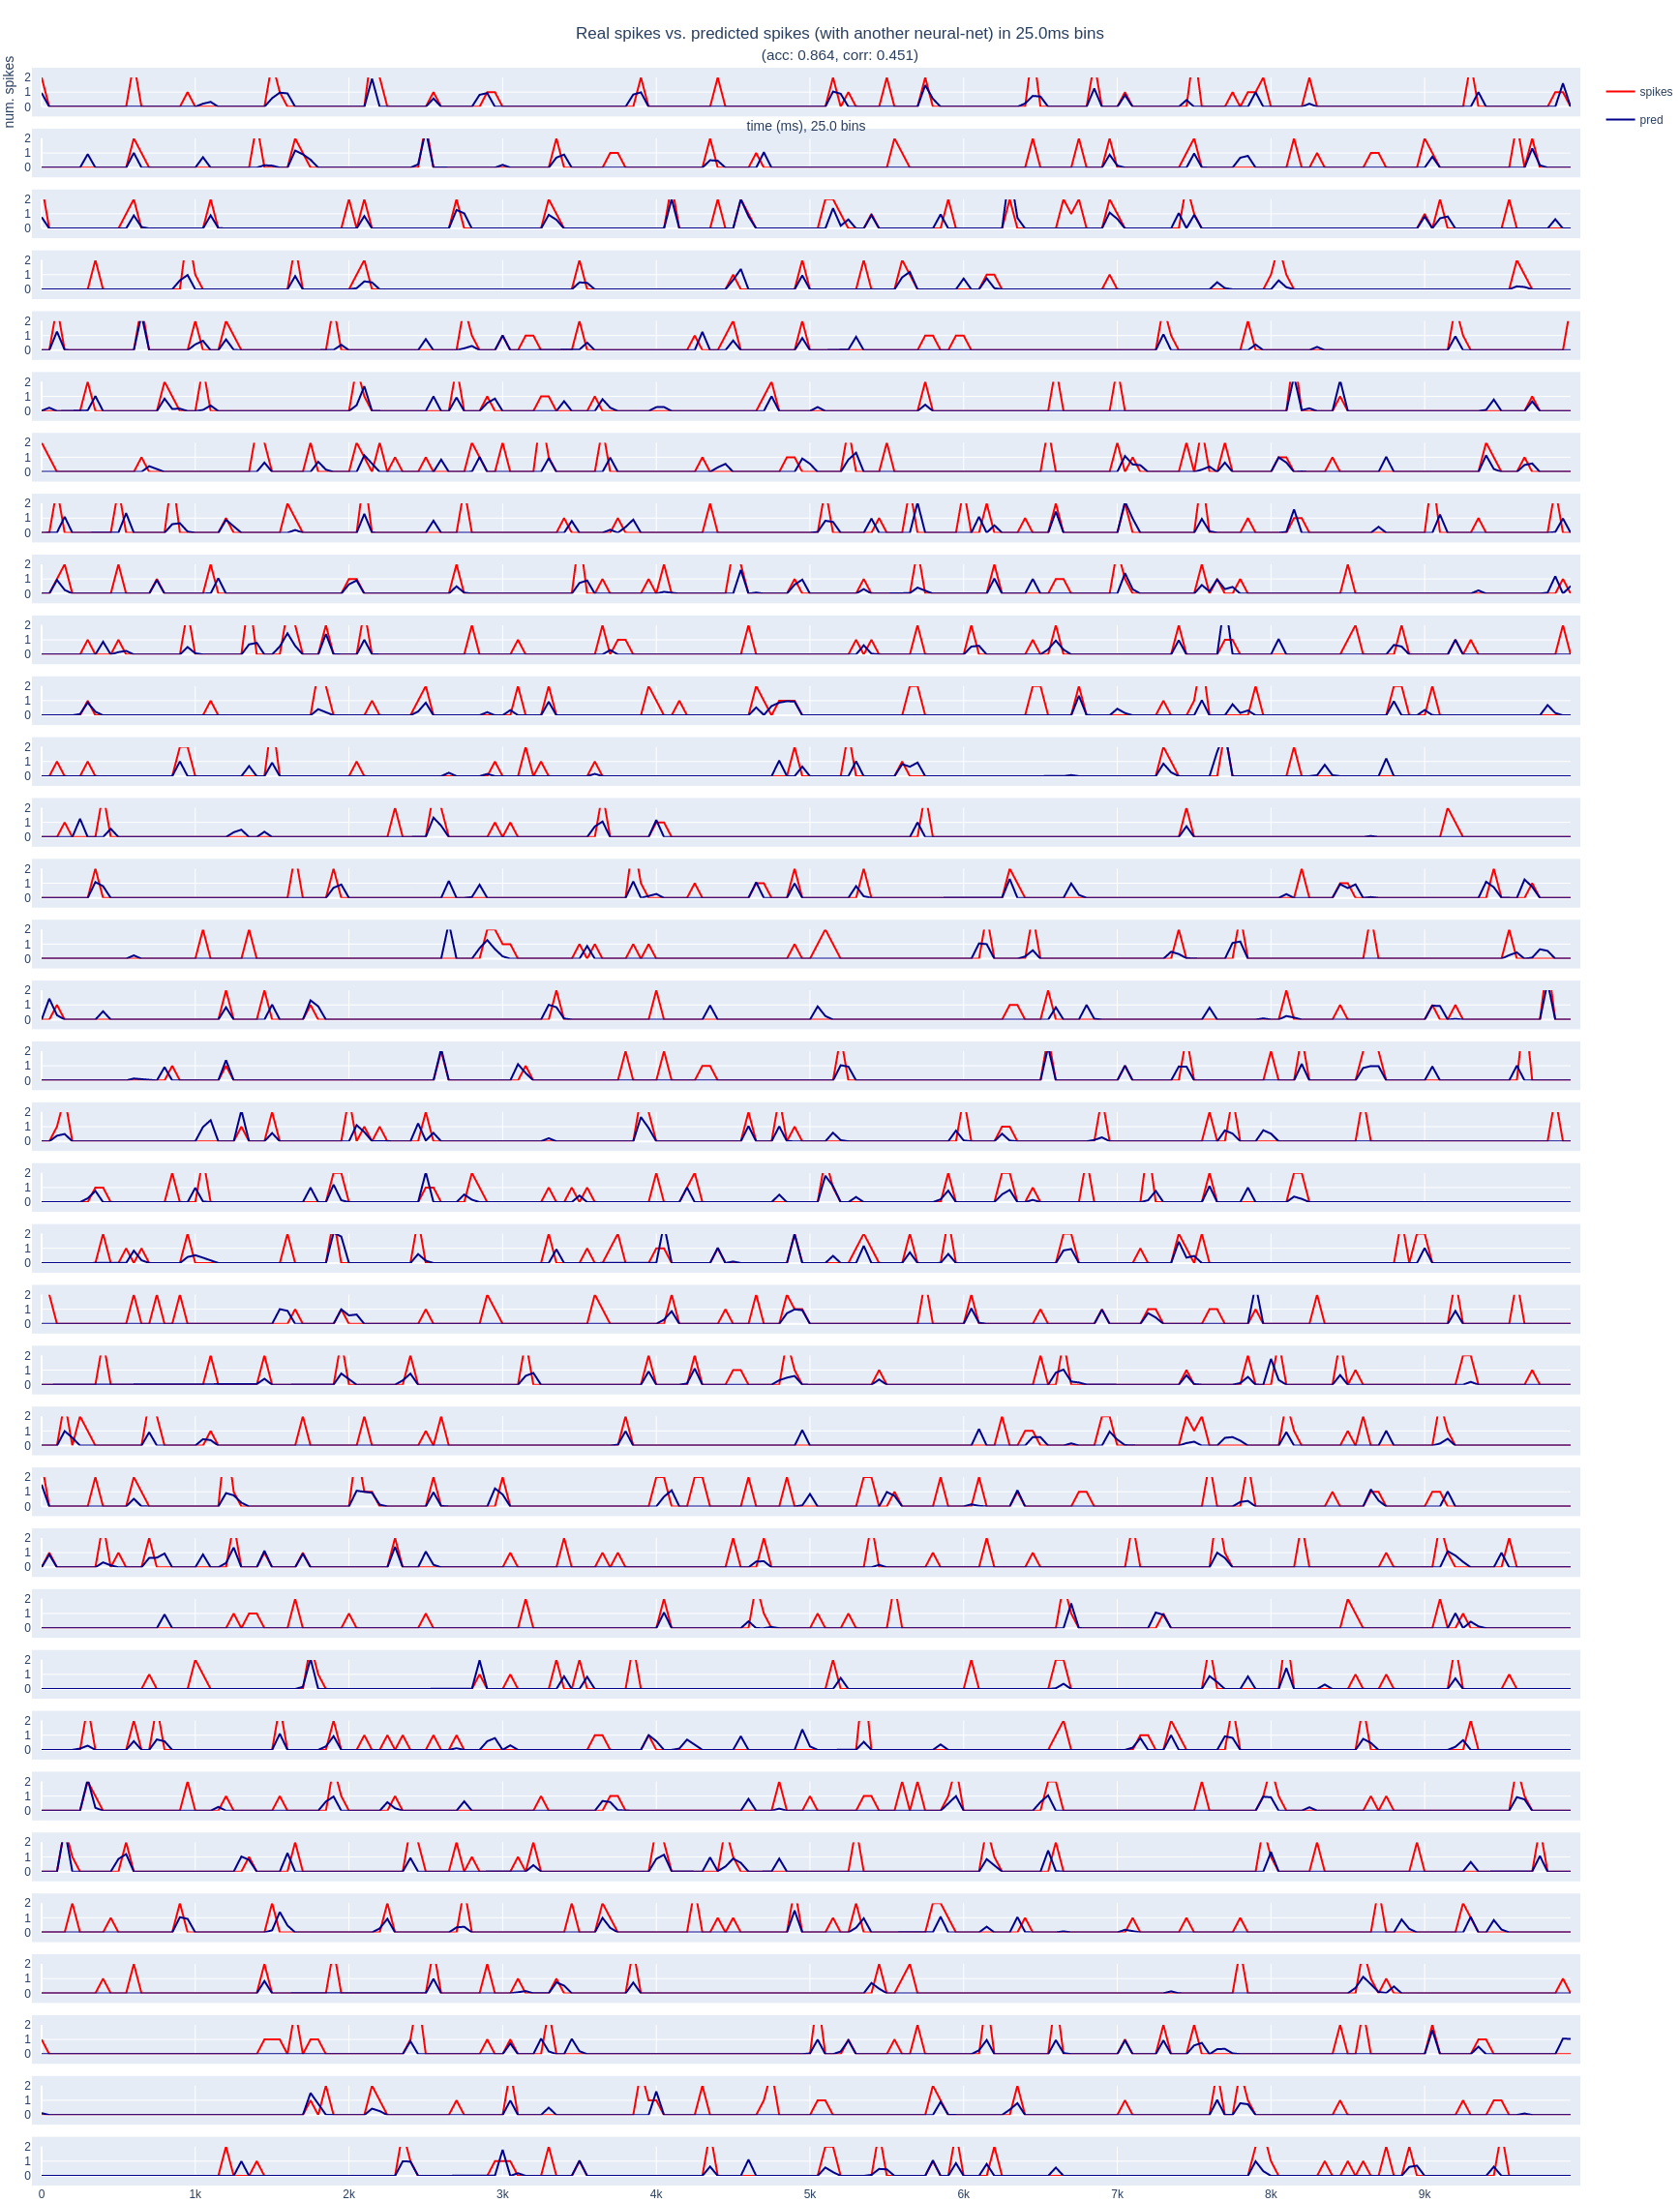

In [47]:
fig = display_results(torch.Tensor(targets), torch.Tensor(predictions), step=trainable.pred_len, chart_type="line")
fig.show()